# import modules

In [2]:
import keras
from keras.utils import plot_model,to_categorical
from keras.layers import Dense,LSTM,Bidirectional,TimeDistributed,Conv1D,MaxPool1D,Concatenate,Dropout,BatchNormalization,Add
from keras import Model,Input
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model


from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np

# Load Features

In [2]:
X_features=np.load('./feature/X_feature.npy')
y=np.load('./feature/y_final.npy')

In [3]:
X_features.shape

(4704, 50, 57)

In [4]:
y.shape

(4704, 4)

In [5]:
y[0]

array(['1', '0', '0', '0'], dtype='<U1')

In [6]:
alphabet_set={'0': 0,'a': 1,'e': 2,'g': 3,'i': 4,'n': 5,'o': 6,'r': 7,'u': 8,'v': 9}

In [7]:
alphabet_set={value:key for key,value in alphabet_set.items()}

## One-hot Encoding

In [8]:
y=to_categorical(y,num_classes=10)

In [9]:
y.shape

(4704, 4, 10)

## split train and test

In [10]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.1,random_state=2019)

In [11]:
X_train.shape,X_test.shape

((4233, 50, 57), (471, 50, 57))

In [12]:
y_train.shape,y_test.shape

((4233, 4, 10), (471, 4, 10))

# Models


In [3]:
NUM_CLASSES=10
BATCH_SIZE=128
EPOCHS=100
MODEL_SAVE_PATH='./models/final_cnn.h5'

In [4]:

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model():
    inputs = Input(shape=(50, 57))

    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(0.3)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = MaxPool1D(pool_size=43, strides=2)(attention_mul)
    output = Dense(10, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [5]:
model = attention_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 57)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 64)       3712        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 50, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 128)      66048       dropout[0][0]                    
_______________________________________________________________________________________

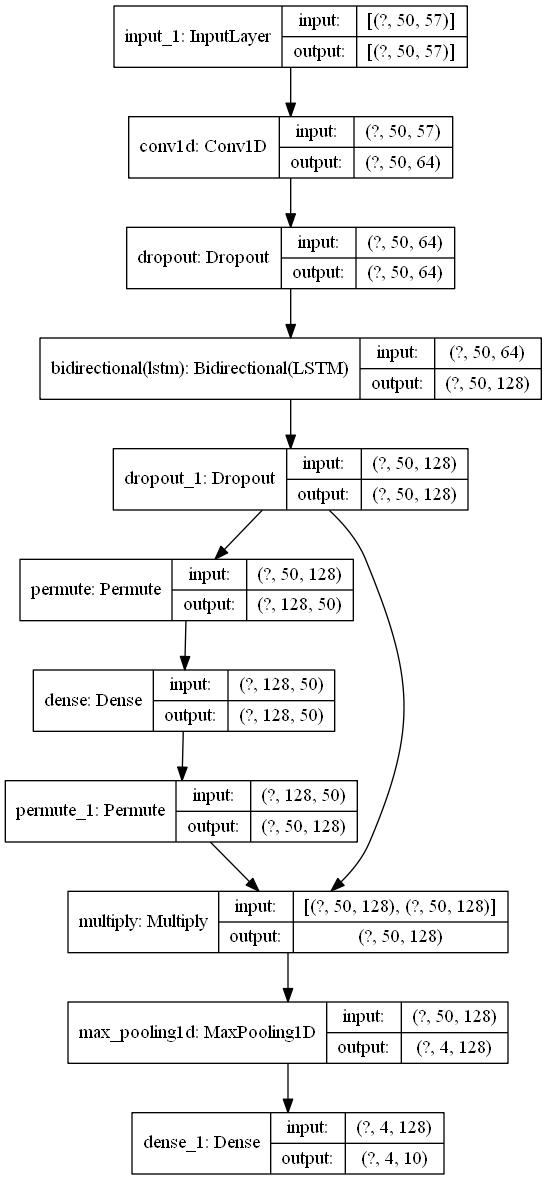

In [7]:
import pydotplus
import graphviz 
from keras.utils import plot_model
plot_model(model, to_file='.\\audio_final.png', show_shapes=True)

In [16]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
plot_model(model,'model_final.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_acc',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
                  callbacks=callback_list)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/100
34/34 [==============================] - 3s 84ms/step - loss: 2.1828 - accuracy: 0.4846 - val_loss: 1.9503 - val_accuracy: 0.5196
Epoch 2/100
34/34 [==============================] - 2s 63ms/step - loss: 1.7500 - accuracy: 0.5021 - val_loss: 1.6594 - val_accuracy: 0.5196
Epoch 3/100
34/34 [==============================] - 2s 62ms/step - loss: 1.6688 - accuracy: 0.5021 - val_loss: 1.6266 - val_accuracy: 0.5196
Epoch 4/100
34/34 [==============================] - 2s 61ms/step - loss: 1.5922 - accuracy: 0.5021 - val_loss: 1.5152 - val_accuracy: 0.5196
Epoch 5/100
34/34 [==============================] - 2s 61ms/step - loss: 1.4539 - accuracy: 0.5021 - val_loss: 1.3969 - val_accuracy: 0.5196
Epoch 6/100
34/34 [==============================] - 2s 62ms/step - loss: 1.3374 - accuracy: 0.5037 - val_loss: 1.3169 - val_accuracy: 0.5796


## plot_curve

In [17]:
from help import plot_curve,plot_curve_with_smooth

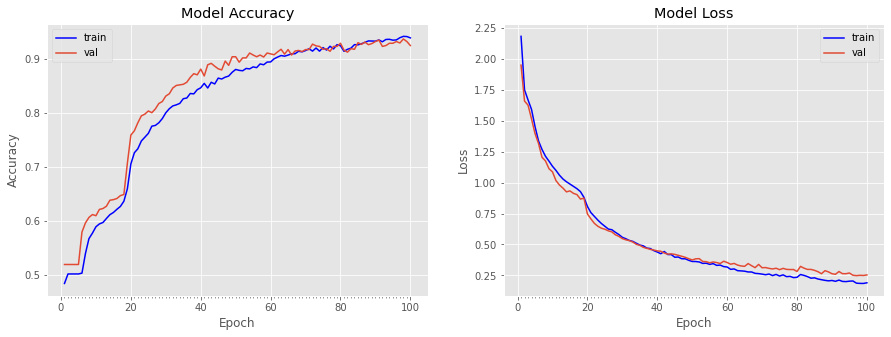

In [18]:
plot_curve(history)

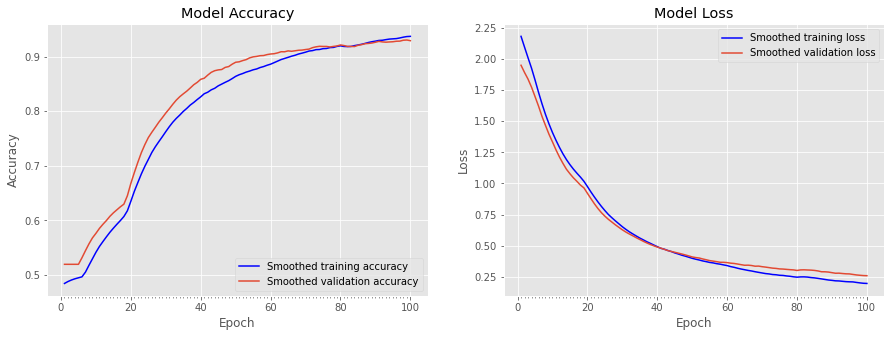

In [19]:
plot_curve_with_smooth(history)

## confusion_metrix

In [19]:
#model.load_weights('./models/final_cnn.h5')

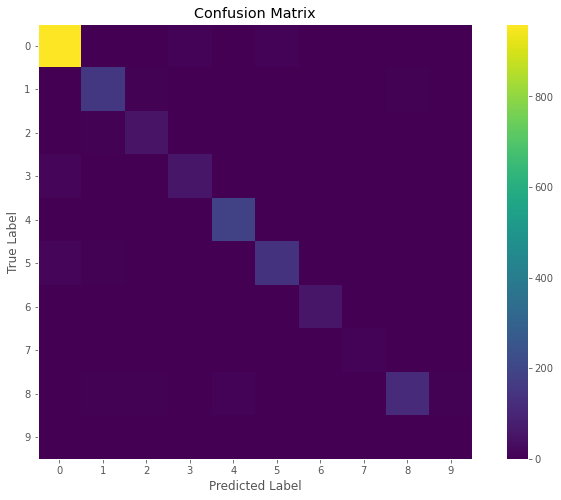

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_test,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize=(12,8))
    plt.imshow(confusion_mat)
    plt.title('Confusion Matrix')
    plt.colorbar()
    labels = list(range(0,10))
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show() 
plot_confusion_matrix(con_matrix)

## classfication_report

In [21]:
from sklearn.metrics import classification_report
#model.load_weights('./models/final_cnn.h5')

In [22]:
target_names=[alphabet_set[i] for i in range(10)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(10)),target_names=target_names))

              precision    recall  f1-score   support

           0     0.9590    0.9806    0.9697       979
           a     0.9023    0.8971    0.8997       175
           e     0.8095    0.8095    0.8095        63
           g     0.8657    0.7945    0.8286        73
           i     0.9082    0.9592    0.9330       196
           n     0.8924    0.8443    0.8677       167
           o     0.9219    0.8429    0.8806        70
           r     1.0000    0.8889    0.9412         9
           u     0.8864    0.8125    0.8478       144
           v     0.3000    0.3750    0.3333         8

    accuracy                         0.9246      1884
   macro avg     0.8445    0.8205    0.8311      1884
weighted avg     0.9244    0.9246    0.9240      1884



# predict test

In [23]:
import librosa
import sklearn
def get_mfcc_feature(path,maxlen=50):
    x, sr = librosa.load(path)
    # extract mfcc
    mfcc = librosa.feature.mfcc(x, sr=sr)
    # Center to the mean and component wise scale to unit variance
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    mfcc_diff = np.diff(mfcc, axis=0)
    mfcc_diff_diff = np.diff(mfcc_diff, axis=0)
    # concatenate mfcc,mfcc_diff and mfcc_diff_diff
    mfccs = np.concatenate([mfcc, mfcc_diff, mfcc_diff_diff], axis=0).T
    #pad the mfccs_feature
    if mfccs.shape[0]<maxlen:
        mfccs=np.concatenate([mfccs,np.zeros((maxlen-mfccs.shape[0],57))],axis=0)
    return mfccs

In [24]:
wav_file='./voice_data/person10_time1_group4_mao_2.wav'
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:ao


In [27]:
wav_file='./voice_data/person10_time1_group1_er_4.wav'
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:er


In [28]:
wav_file='./voice_data/person10_time1_group1_liu_4.wav'
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:iu
